# Functional Control of Kuramoto Oscillators

##### Ramón Nartallo

1. Install the dependencies and import the helper functions

In [29]:
import numpy as np
import math as m
import random as r
import cvxpy as cp
from scipy.integrate import odeint
import seaborn as sns
import KuramotoFunctionBank as KFB
import importlib
import matplotlib.pyplot as plt
importlib.reload(KFB)

<module 'KuramotoFunctionBank' from '/home/nartallokalu/Desktop/kuramotocontrol/KuramotoFunctionBank.py'>

Control parameters and generate a random adjacency matrix and frequencies from which to optimise from

In [30]:
#Parameter control center
N=7

#These are phases differences w.r.t osc 1
x_min = np.array([0, m.pi/8, m.pi/8, m.pi/6, m.pi/6, m.pi/3, 2*m.pi/3])

#Random adjacency matrix
A = np.zeros((N,N))
for i in range(0,N-1):
    for j in range(i+1,N):
        u=r.uniform(0,1)
        if u >0.1:
            A[i][j]=2
A = A + np.transpose(A)

#Random natural frequencies
w = 2*np.random.rand(N,1)
w = w-np.mean(w)


Visualise the desired functional pattern as a colour matrix plot

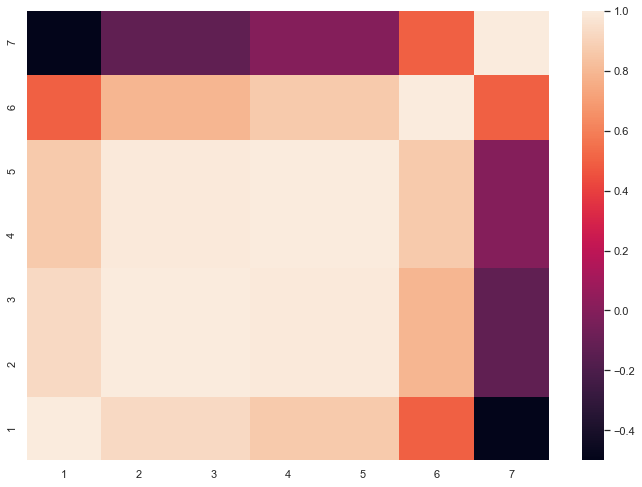

In [31]:
#Form correlation matrix from vector of desired frequencies
Rho = KFB.CalculateCorrelationMatrix(x_min)
ax1= sns.heatmap(Rho.T,xticklabels='1234567',yticklabels='1234567')
ax1.invert_yaxis()
plt.show()

Calculate some key quantities using helper functions

In [32]:
#Calculate quantities from inital parameters 

edges = KFB.CalculateEdgeSet(A)
x_desired = KFB.CalculatePhaseDifferencesFromMin(x_min,edges)
D = KFB.CalculateSinMatrix(edges,x_desired)
B = KFB.CalculateIncidenceMatrix(edges,N)
B_D = np.matmul(B,D)
delta1 = KFB.CalculateDeltaFromAdj(A,edges)

Solve the convex optimisation problem numerically

In [51]:
# Construct the problem and solve the convex optimisation problem
delta = cp.Variable((len(edges),1))
beta = cp.Variable((N,1))
objective = cp.Minimize(cp.sum_squares(delta-delta1)+ cp.sum_squares(beta))
constraints = [B_D@delta==w+beta,delta >=10^-20]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#Reobtain adjacency from delta vector and update frequencies
A = KFB.CalculateAdjFromDelta(delta.value,edges,N)
delta = delta.value
w = w+beta.value

Integrate the Kuramoto model using these calculated parameters

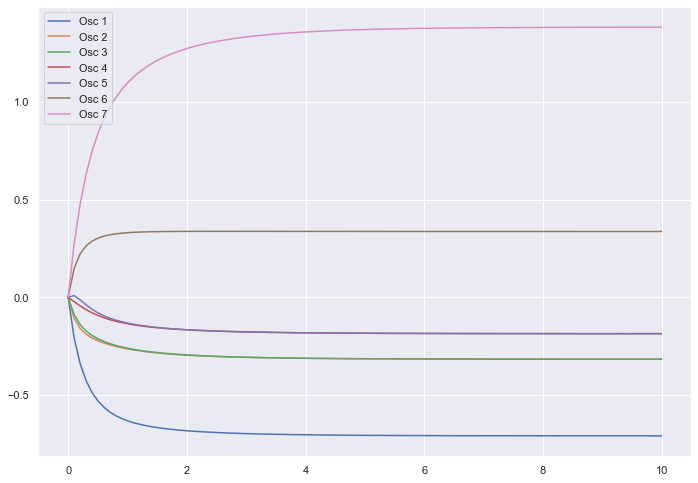

In [52]:
#Solving the model with these params
theta_0 = np.zeros(N)
T=10
num_points = 100

sol,t = KFB.SolveKuramotoModel(theta_0,T,N,w,A,num_points)

#Plot oscillator trajcetories
for i in range(0,N):
    ax = sns.lineplot(x=t,y=sol[:,i],label =str("Osc " + str(i+1)))

Compare the acheived functional pattern to the desired functional pattern as matrix colour plots


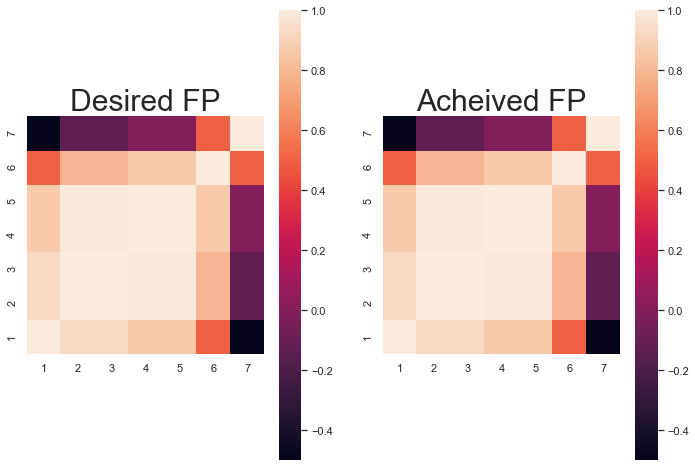

In [53]:
#Plot the acheived functional pattern to compare to the desired functional pattern
x_acheived = KFB.CalculatePhaseDiffs(sol[num_points-1,:])
Rho_acheived = KFB.CalculateCorrelationMatrix(x_acheived)
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.title.set_text('Desired FP')
ax1.title.set_size(30)
ax2.title.set_text('Acheived FP')
ax2.title.set_size(30)
sns.heatmap(Rho.T, ax=ax1,square=True,xticklabels='1234567',yticklabels='1234567')
sns.heatmap(Rho_acheived.T, ax=ax2,square = True,xticklabels='1234567',yticklabels='1234567')
ax1.invert_yaxis()
ax2.invert_yaxis()
plt.show()


Perform same optimisation to acheive new functional pattern: display the current functional pattern to compare to the desired

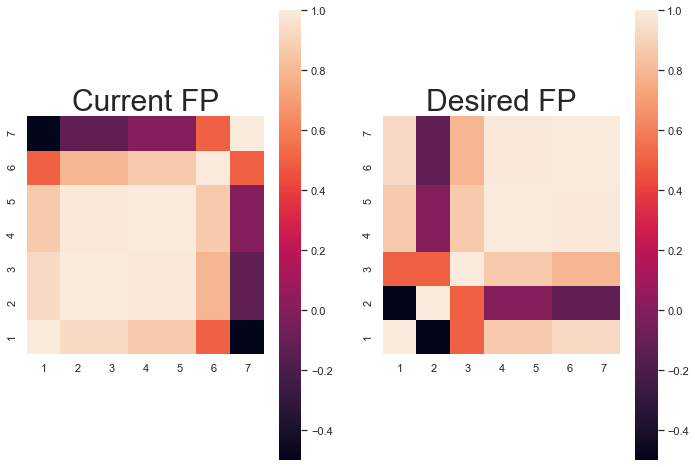

In [65]:
#These are phases differences w.r.t osc 1
x_min_2 = [0,2*m.pi/3, m.pi/3, m.pi/6, m.pi/6, m.pi/8, m.pi/8]
Rho_2 = KFB.CalculateCorrelationMatrix(x_min_2)
x_desired_2 = KFB.CalculatePhaseDifferencesFromMin(x_min_2,edges)


#Plot current and desired functional patterns
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.title.set_text('Current FP')
ax1.title.set_size(30)
ax2.title.set_text('Desired FP')
ax2.title.set_size(30)
sns.heatmap(Rho.T, ax=ax1,square=True,xticklabels='1234567',yticklabels='1234567')
sns.heatmap(Rho_2.T, ax=ax2,square = True,xticklabels='1234567',yticklabels='1234567')
ax1.invert_yaxis()
ax2.invert_yaxis()
plt.show()


Numerically solve the optimisation problem for smallest increment

In [95]:
D_2 = KFB.CalculateSinMatrix(edges,x_desired_2)
B_D_2 = np.matmul(B,D_2)


# Construct the problem and solve the convex optimisation problem
alpha = cp.Variable((len(edges),1))
phi = cp.Variable((N,1))
objective2 = cp.Minimize(cp.sum_squares(alpha)+cp.sum_squares(phi))
constraints2 = [B_D_2@(delta+alpha)==(w+phi),delta + alpha>=0]
prob2 = cp.Problem(objective2, constraints2)
result2 = prob2.solve()
#Reobtain adjacency from delta vector and update frequencies
A_c = KFB.CalculateAdjFromDelta(delta+alpha.value,edges,N)
w_c = w+phi.value

#Resolve Kuramoto with the params
sol_2,t = KFB.SolveKuramotoModel(theta_0,T,N,w_c,A_c,num_points)
x_acheived_2 = KFB.CalculatePhaseDiffs(sol_2[num_points-1,:])

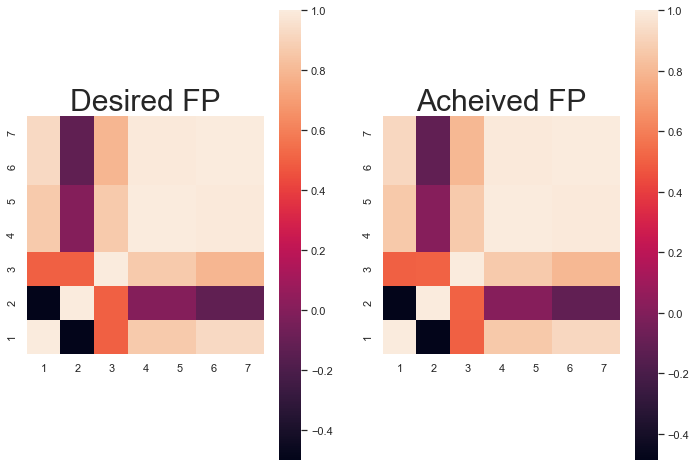

In [96]:
Rho_acheived_2 = KFB.CalculateCorrelationMatrix(x_acheived_2)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.title.set_text('Desired FP')
ax1.title.set_size(30)
ax2.title.set_text('Acheived FP')
ax2.title.set_size(30)
sns.heatmap(Rho_2.T, ax=ax1,square = True,xticklabels='1234567',yticklabels='1234567')
sns.heatmap(Rho_acheived_2.T, ax=ax2,square = True,xticklabels='1234567',yticklabels='1234567')
ax1.invert_yaxis()
ax2.invert_yaxis()
plt.show()


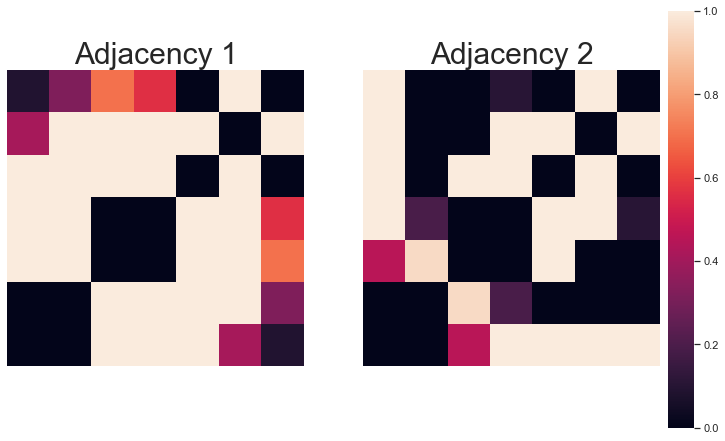

In [103]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.title.set_text('Adjacency 1')
ax1.title.set_size(30)
ax2.title.set_text('Adjacency 2')
ax2.title.set_size(30)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
sns.heatmap(A.T, ax=ax1,square = True,xticklabels='',yticklabels='',cbar_ax=cbar_ax,vmin=0,vmax=1)
sns.heatmap(A_c.T, ax=ax2,square = True,xticklabels='',yticklabels='',cbar_ax=cbar_ax,vmin=0,vmax=1)
ax1.invert_yaxis()
ax2.invert_yaxis()
plt.show()


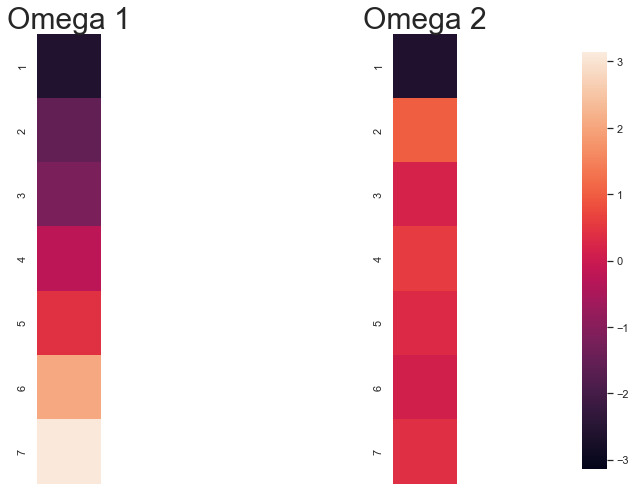

In [111]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.title.set_text('Omega 1')
ax1.title.set_size(30)
ax2.title.set_text('Omega 2')
ax2.title.set_size(30)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
sns.heatmap(w, ax=ax1,square = True,xticklabels='',yticklabels='1234567',cbar_ax=cbar_ax,vmin=-m.pi,vmax=m.pi)
sns.heatmap(w_c, ax=ax2,square = True,xticklabels='',yticklabels='1234567',cbar_ax=cbar_ax,vmin=-m.pi,vmax=m.pi)
plt.show()